In [28]:
# Little helper functions
# Click on the 'eye' in the toolbar to hide the source code

from IPython.display import display, Markdown, Latex
import numpy as np
import matplotlib.pyplot as plt

# like print but with markdown
def show(s):
    display(Markdown(s))

# joins arrays to strings
def join(sym, a):
    return sym.join([str(e) for e in a])

# joins arrays with format pattern   
def joinf(sym, f, a):
    return sym.join([(f % e) for e in a])

# divides all elements through the sum of all elements
def norm(fs):
    s = float(np.sum(fs))
    return np.array([f/s for f in fs])

# calculates the mean value as product of probability and value
mean =  lambda ps, xs: np.sum([ps[i] * xs[i] for i in range(len(xs))])

# Historic Data

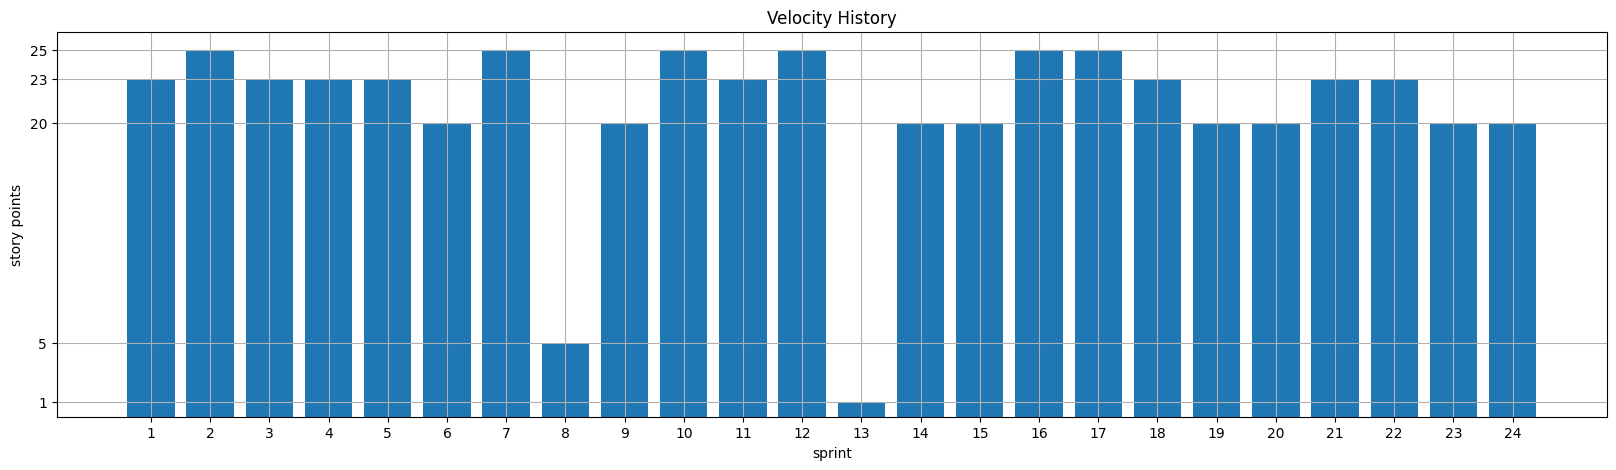

In [29]:
# enter your team's velocity distribution here
velocity_values =  [1, 5, 20, 23, 25]
velocity_frequencies = [1, 1, 3, 4, 2]    

velocity_probabilities = norm(velocity_frequencies)            # normed frequencies
story_points_completed = np.random.choice(a=velocity_values, size=24, p=velocity_probabilities)

fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Velocity History')
plt.bar(np.arange(len(story_points_completed)), story_points_completed)

ax.set_ylabel('story points')
plt.yticks(velocity_values, velocity_values)

ax.set_xlabel('sprint')
plt.xticks(np.arange(len(story_points_completed)), np.arange(1, len(story_points_completed) + 1))
plt.grid()
plt.show()

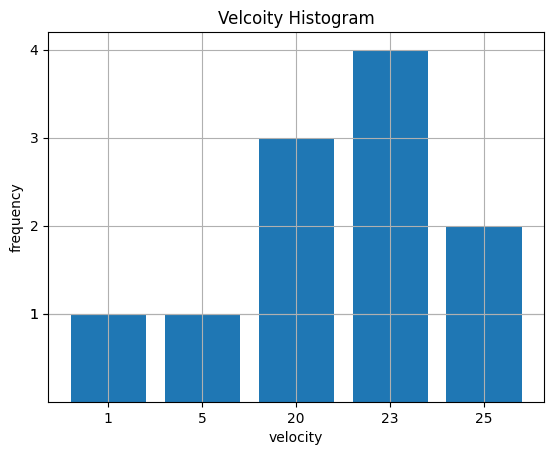

In [30]:
fig, ax = plt.subplots()
plt.title('Velcoity Histogram')
plt.bar(np.arange(len(velocity_frequencies)), velocity_frequencies)

ax.set_ylabel('frequency')
plt.yticks(velocity_frequencies, velocity_frequencies)

ax.set_xlabel('velocity')
plt.xticks(np.arange(len(velocity_values)), velocity_values)
plt.grid()
plt.show()

# Sample Project

In [31]:
story_points_total = 50
show('**Fixed price project $n = %d$ story points**' % story_points_total)


**Fixed price project $n = 50$ story points**

## Special Cases

$S$ ...number of sprints

$V$ ...velocity

$P$ ...probability

Worst case: $S_{max}=n/min(V), P(S_{max}) = P(min(V))^{S_{min}}$

Best case: $S_{min}=n/max(V), P(S_{min}) = P(max(V))^{S_{max}}$

Average case: $\overline{S}=n/\overline{V}$


In [32]:
sprints_max = story_points_total/np.min(velocity_values)
probability_max = velocity_probabilities[0] ** sprints_max

show('Worst case: $S_{max} = %1.2f, P(S_{max}) = %e$ %%' % (sprints_max, probability_max * 100))

sprints_min = story_points_total/np.max(velocity_values)
probability_min = velocity_probabilities[-1] ** sprints_min

show('Best case: $S_{min} = %1.2f, P(S_{min}) = %1.2f$ %%' % (sprints_min, probability_min * 100))

velocity_mean = mean(velocity_probabilities, velocity_values)
sprints_mean = story_points_total/velocity_mean

show('Average case:  $\overline{V} = %1.2f => \overline{S} = %1.2f$' % (velocity_mean, sprints_mean))

Worst case: $S_{max} = 50.00, P(S_{max}) = 8.518551e-51$ %

Best case: $S_{min} = 2.00, P(S_{min}) = 3.31$ %

Average case:  $\overline{V} = 18.91 => \overline{S} = 2.64$

# Monte Carlo Simulation

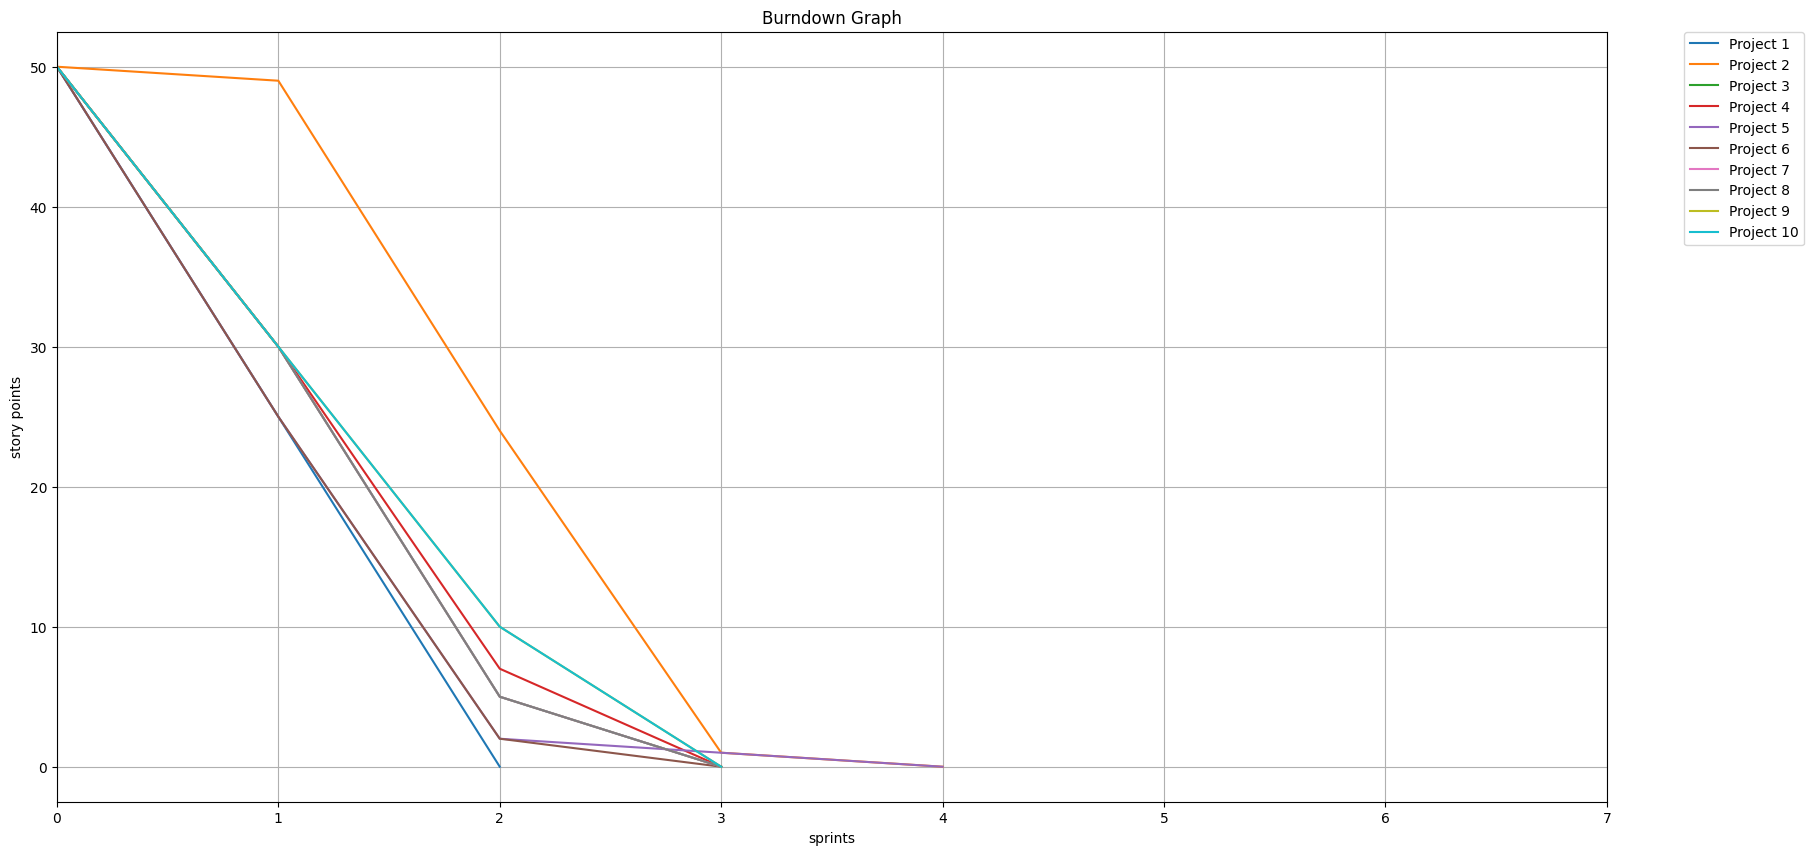

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))

# simulate 10 projects
projects = 10
sprints_max = sprints_max.astype(np.int64)

for project in range(projects):
    story_points_completed = []
    burndown = [story_points_total]

    for sprint in range(sprints_max):
        story_points_completed.append(np.random.choice(a=velocity_values, size=1, p=velocity_probabilities))
        story_points_left = max(0, story_points_total - np.sum(story_points_completed))
        burndown.append(story_points_left)

        if story_points_left == 0:
            break

    plt.plot(np.arange(len(burndown)), burndown, label="Project %d" % (project + 1))

plt.title('Burndown Graph')
ax.set_ylabel('story points')
ax.set_xlabel('sprints')
ax.set_xlim(0, 7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()


In [34]:
projects = 5000

show("**Number of simulated projects: $m = %d$**" % projects)

**Number of simulated projects: $m = 5000$**

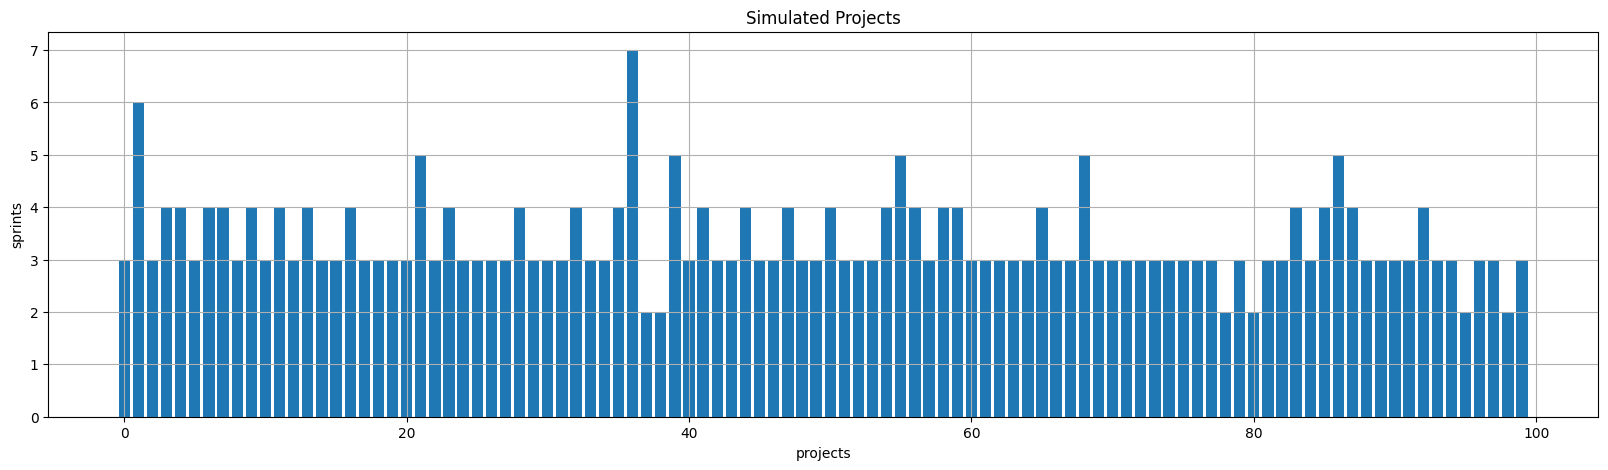

In [35]:
project_sprints = np.zeros(projects) # sprints per project

for project in range(projects):
    story_points_completed = []

    for sprint in range(sprints_max):
        story_points_completed.append(np.random.choice(a=velocity_values, size=1, p=velocity_probabilities))
        story_points_left = max(0, story_points_total - np.sum(story_points_completed))

        if story_points_left == 0:
            break
            
    project_sprints[project] = sprint + 1
    
# show the first 100 projects
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Simulated Projects')
plt.bar(np.arange(min(projects, 100)), project_sprints[:min(projects, 100)])
ax.set_ylabel('sprints')
ax.set_xlabel('projects')
plt.grid()
plt.show()


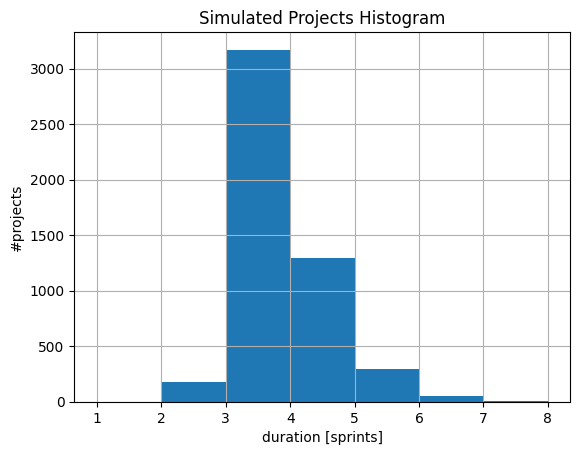

In [36]:
fig, ax = plt.subplots()
plt.title('Simulated Projects Histogram')
plt.hist(project_sprints, bins=np.arange(1, np.max(project_sprints) + 1))
ax.set_ylabel('#projects')
ax.set_xlabel('duration [sprints]')
plt.grid()
plt.show()


# Bad Case: Guaranteed 95% Success

In [37]:
sprint_frequencies, sprints = np.histogram(project_sprints, bins=np.arange(1, np.max(project_sprints) + 1))

table = '|Sprints S|%s|\n' % joinf('|', '%d', sprints[:-1])
table += '|-|%s|\n' % join('|', '-' * len(sprint_frequencies))
table += '|Probability P|%s|\n' % joinf('|', '%1.4f', norm(sprint_frequencies))

show(table)

# p, s in (ps, xs) where p < 1-limit. If all p >= 1-limit, the last entries are taken.
def quantile(ps, xs, limit):
    q = 1 - limit
    p_x = (ps[-1], xs[-1])
    for i in range(len(ps) - 1, 0, -1):
        if ps[i] < q:
            p_x = (ps[i], xs[i])
        else:
            break
    
    return p_x

probability_bad, sprints_bad = quantile(norm(sprint_frequencies), sprints, 0.95)

show('Bad case: $S_{bad} = S(P>0.95) = %1.2f, P(S\le6) = %1.2f $ %%' % (sprints_bad, (1 - probability_bad) * 100))

|Sprints S|1|2|3|4|5|6|7|
|-|-|-|-|-|-|-|-|
|Probability P|0.0000|0.0350|0.6342|0.2588|0.0594|0.0110|0.0016|


Bad case: $S_{bad} = S(P>0.95) = 6.00, P(S\le6) = 98.90 $ %

# Expected Gain

In [38]:
show('Sprints sold: $S_{sold} = %1.2f$' % sprints_bad)
show('Expected number of sprints: $\overline{S} = %1.2f$' % sprints_mean)
show('Expected gain: $S_{sold} - \overline{S} = %1.2f$' % (sprints_bad - sprints_mean))

Sprints sold: $S_{sold} = 6.00$

Expected number of sprints: $\overline{S} = 2.64$

Expected gain: $S_{sold} - \overline{S} = 3.36$